In [2]:
import pandas as pd
import matplotlib.pyplot  as plt

import seaborn as sns
import ipywidgets as widgets
from IPython.display import display


from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [5]:
ball_data = pd.read_csv("ipl 2020 ball-by-ball.csv")
ball_data.head()

,id,inning,over,ball,batsman,non_striker,bowler,batsman_runs,extra_runs,total_runs,non_boundary,is_wicket,dismissal_kind,player_dismissed,fielder,extras_type,batting_team,bowling_team
0,1216493,1,7,3,RR Pant,SS Iyer,CJ Jordan,0,0,0,0,0,NaN,NaN,NaN,NaN,Delhi Capitals,Kings XI Punjab
1,1216493,1,7,4,RR Pant,SS Iyer,CJ Jordan,1,0,1,0,0,NaN,NaN,NaN,NaN,Delhi Capitals,Kings XI Punjab
2,1216493,1,7,5,SS Iyer,RR Pant,CJ Jordan,0,0,0,0,0,NaN,NaN,NaN,NaN,Delhi Capitals,Kings XI Punjab
3,1216493,1,7,6,SS Iyer,RR Pant,CJ Jordan,1,0,1,0,0,NaN,NaN,NaN,NaN,Delhi Capitals,Kings XI Punjab
4,1216493,1,7,7,RR Pant,SS Iyer,CJ Jordan,1,0,1,0,0,NaN,NaN,NaN,NaN,Delhi Capitals,Kings XI Punjab


In [12]:
ball_data.shape

(14266, 18)

In [9]:
match_data = pd.read_csv("IPL 2020 matches.csv")
match_data.head()

,id,city,date,player_of_match,venue,neutral_venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,eliminator,method,umpire1,umpire2
0,1216493,Dubai,2020-09-20,MP Stoinis,Dubai International Cricket Stadium,0,Delhi Capitals,Kings XI Punjab,Kings XI Punjab,field,Delhi Capitals,tie,NaN,Y,NaN,AK Chaudhary,Nitin Menon
1,1216494,Abu Dhabi,2020-10-21,Mohammed Siraj,Sheikh Zayed Stadium,0,Kolkata Knight Riders,Royal Challengers Bangalore,Kolkata Knight Riders,bat,Royal Challengers Bangalore,wickets,8.0,N,NaN,VK Sharma,S Ravi
2,1216495,Sharjah,2020-11-03,S Nadeem,Sharjah Cricket Stadium,0,Mumbai Indians,Sunrisers Hyderabad,Sunrisers Hyderabad,field,Sunrisers Hyderabad,wickets,10.0,N,NaN,C Shamshuddin,RK Illingworth
3,1216496,Sharjah,2020-09-22,SV Samson,Sharjah Cricket Stadium,0,Rajasthan Royals,Chennai Super Kings,Chennai Super Kings,field,Rajasthan Royals,runs,16.0,N,NaN,C Shamshuddin,VA Kulkarni
4,1216497,Abu Dhabi,2020-10-24,CV Varun,Sheikh Zayed Stadium,0,Kolkata Knight Riders,Delhi Capitals,Delhi Capitals,field,Kolkata Knight Riders,runs,59.0,N,NaN,CB Gaffaney,PG Pathak


In [10]:
match_data.shape

(59, 17)

In [13]:
#check for missing data
ball_data.isnull().sum()

id                      0
inning                  0
over                    0
ball                    0
batsman                 0
non_striker             0
bowler                  0
batsman_runs            0
extra_runs              0
total_runs              0
non_boundary            0
is_wicket               0
dismissal_kind      13612
player_dismissed    13612
fielder             13821
extras_type         13577
batting_team            0
bowling_team            0
dtype: int64

In [43]:
#Create batsman group
batsman_grp = ball_data.groupby(['batsman'])

# Create a batting dataframe with statistics for each batsman
batdf = pd.DataFrame(batsman_grp['ball'].count()).rename(columns={'ball':'balls_faced'})
batdf['innings'] = batsman_grp['id'].nunique()
batdf['runs'] = batsman_grp['batsman_runs'].sum()
#how many 4s and 6s each batsman hit
batdf['4s'] = ball_data[ball_data['batsman_runs'] == 4].groupby('batsman')['batsman_runs'].count()
batdf['4s'].fillna(0,inplace=True)
batdf['6s'] = ball_data[ball_data['batsman_runs'] == 6].groupby('batsman')['batsman_runs'].count()
batdf['6s'].fillna(0,inplace=True)
#finding batting average and strike rate
# Batting average = total rus scored/no of matches
batdf['average_runs'] = round(batdf['runs']/batdf['innings'],2)
# Strike Rate = (Runs Scored / Balls faced) * 100
batdf['strike_rate'] = round(batdf['runs']/batdf['balls_faced']*100,2)
batdf.head()

,balls_faced,innings,runs,4s,6s,average_runs,strike_rate
batsman,,,,,,,
A Nortje,6,3,7,0.0,0.0,2.33,116.67
AB de Villiers,292,14,454,33.0,23.0,32.43,155.48
AD Russell,82,9,117,9.0,9.0,13.00,142.68
AJ Finch,254,12,268,28.0,8.0,22.33,105.51
AJ Tye,7,1,6,0.0,1.0,6.00,85.71


In [21]:
#find what are the different types of dismissals
ball_data['dismissal_kind'].unique()

array([nan, 'caught', 'run out', 'bowled', 'lbw', 'stumped',
       'caught and bowled', 'hit wicket'], dtype=object)

In [38]:
#create bowler groups
bowlgroup = ball_data.groupby(['bowler'])

# Create a bowling dataframe which contains stats for each player
bowldf = pd.DataFrame(bowlgroup['ball'].count()).rename(columns={'ball':'balls_bowled'})

# Calculate the total no. of overs bowled
overs_bowled = pd.DataFrame(ball_data.groupby(['bowler','id'])['over'].nunique())
bowldf['overs'] = overs_bowled.groupby(['bowler'])['over'].sum()    

# No of wickets each bowler took
bowler_wickets = ball_data[ball_data['dismissal_kind'].isin(['caught','bowled', 'lbw','stumped', 'caught and bowled', 'hit wicket'])]
bowldf['wickets'] = bowler_wickets.groupby(['bowler'])['ball'].count()
bowldf['wickets'].fillna(0,inplace=True)

# Calculate the runs conceded
bowldf['runs_given'] = ball_data.groupby('bowler')['batsman_runs'].sum()
bowldf['runs_given'] = bowldf['runs_given'].fillna(0)
# Add the runs conceded through wide and noball
bowldf['runs_given'] = bowldf['runs_given'].add(ball_data[ball_data['extras_type'].isin(['wides','noballs'])].groupby('bowler')['extra_runs'].sum(),fill_value=0)
#finding bowler economy
bowldf['economy'] = round(bowldf['runs_given']/bowldf['overs'],2)
bowldf.head()

,balls_bowled,overs,wickets,runs_given,economy
bowler,,,,,
A Mishra,61,10,3.0,72.0,7.20
A Nortje,376,62,22.0,512.0,8.26
A Zampa,67,11,2.0,92.0,8.36
AD Russell,114,18,6.0,175.0,9.72
AJ Tye,27,4,1.0,49.0,12.25


In [64]:
#Scale the batting data
scaler = StandardScaler()
# fit_transform
batdf_scaled = pd.DataFrame(scaler.fit_transform(batdf),columns=batdf.columns)
batdf_scaled.shape
batdf_columns= list(batdf_scaled.columns)
batdf_scaled.head()

,balls_faced,innings,runs,4s,6s,average_runs,strike_rate
0,-0.834320,-0.716306,-0.805900,-0.781502,-0.761840,-1.064922,0.271975
1,1.465845,1.510471,1.904376,1.378706,2.375767,1.489772,1.188710
2,-0.223088,0.498300,-0.138942,-0.192354,0.465919,-0.159321,0.886360
3,1.160229,1.105603,0.776610,1.051402,0.329501,0.632550,0.008364
4,-0.826278,-1.121174,-0.811963,-0.781502,-0.625423,-0.753436,-0.459334


In [65]:
#Scale the bowling data
scaler = StandardScaler()
# fit_transform
bowldf_scaled = pd.DataFrame(scaler.fit_transform(bowldf),columns=bowldf.columns)
bowldf_scaled.shape
bowldf_columns= list(bowldf_scaled.columns)
bowldf_scaled.head()

,balls_bowled,overs,wickets,runs_given,economy
0,-0.731149,-0.718346,-0.483099,-0.850460,-0.736502
1,1.992134,2.031985,2.354535,2.288982,-0.214870
2,-0.679277,-0.665455,-0.632448,-0.707758,-0.165659
3,-0.272946,-0.295218,-0.035051,-0.115545,0.503605
4,-1.025091,-1.035692,-0.781797,-1.014567,1.748634


In [46]:
#finding optimum number of clusters for batting data
def elbow_plot(min_k, max_k, k_max_iter):
    # Elbow-curve/sum of squared distances
    sum_squared_distances = []
    k_range = range(min_k, max_k+1)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, max_iter=k_max_iter)
        kmeans.fit(batdf_scaled)

        sum_squared_distances.append(kmeans.inertia_)

    # Plot the score for each value of k
    plt.plot(k_range, sum_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum of squared distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

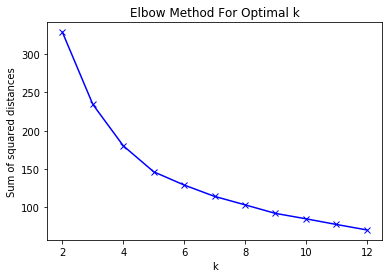

In [47]:
elbow_plot(2,12, 50)
#The optimum number of clusters is 5

In [87]:
#removing players with low strike rate
batdf = batdf[batdf["strike_rate"] > 40]

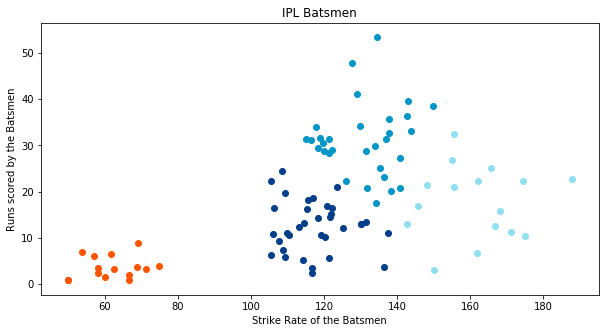

In [137]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)
kmeans.fit(batdf[["strike_rate", "average_runs"]])
batdf["cluster"] = kmeans.labels_

fig = plt.figure(figsize=(10,5))
custom_colors = ["#023e8a", "#0096c7","#90e0ef","#ff5400","#ffbd00"]
colors = custom_colors

for r in range(1,6):
    clustered_Batsmen = batdf[batdf["cluster"] == r]
    plt.scatter(clustered_Batsmen["strike_rate"], clustered_Batsmen["average_runs"], color=colors[r-1])
    
plt.title("IPL Batsmen")
plt.xlabel("Strike Rate of the Batsmen")
plt.ylabel("Runs scored by the Batsmen")
plt.show()

In [89]:
batdf_display = batdf.sort_values(by='cluster')
batdf_display.head(5)

,balls_faced,innings,runs,4s,6s,average_runs,strike_rate,cluster
batsman,,,,,,,,
NM Coulter-Nile,15,2,25,4.0,0.0,12.50,166.67,0
CH Morris,21,5,34,2.0,3.0,6.80,161.90,0
SV Samson,242,14,375,21.0,26.0,26.79,154.96,0
TU Deshpande,12,2,21,2.0,1.0,10.50,175.00,0
Abdul Samad,66,7,111,8.0,6.0,15.86,168.18,0
JC Archer,66,10,113,5.0,10.0,11.30,171.21,0
DS Kulkarni,2,1,3,0.0,0.0,3.00,150.00,0
LH Ferguson,29,2,43,4.0,1.0,21.50,148.28,0
HH Pandya,153,12,267,14.0,23.0,22.25,174.51,0


In [90]:
batdf_display.tail(5)

,balls_faced,innings,runs,4s,6s,average_runs,strike_rate,cluster
batsman,,,,,,,,
M Prasidh Krishna,4,2,2,0.0,0.0,1.00,50.00,4
SN Thakur,21,2,12,0.0,0.0,6.00,57.14,4
Kuldeep Yadav,21,2,13,1.0,0.0,6.50,61.90,4
Shivam Mavi,14,3,10,1.0,0.0,3.33,71.43,4
DW Steyn,2,1,1,0.0,0.0,1.00,50.00,4


In [95]:

#finding optimum number of clusters for bowling data
def elbow_plot_bowl(min_k, max_k, k_max_iter):
    # Elbow-curve/sum of squared distances
    sum_squared_distances = []
    k_range = range(min_k, max_k+1)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, max_iter=k_max_iter)
        kmeans.fit(bowldf_scaled)

        sum_squared_distances.append(kmeans.inertia_)

    # Plot the score for each value of k
    plt.plot(k_range, sum_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum of squared distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

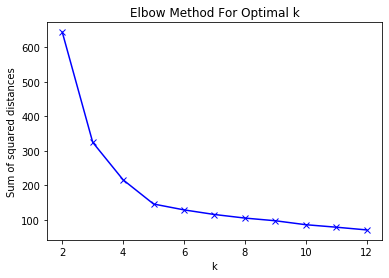

In [96]:
elbow_plot(2,12, 50)
#The optimum number of clusters is 4

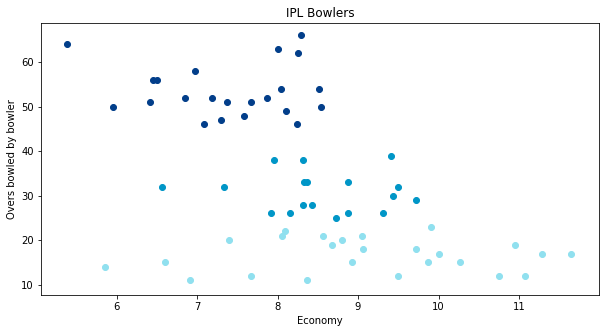

In [136]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)
kmeans.fit(bowldf[["economy", "overs"]])
bowldf["cluster_b"] = kmeans.labels_

fig = plt.figure(figsize=(10,5))
custom_colors = ["#023e8a", "#0096c7","#90e0ef","#ff5400"]
colors = custom_colors

for r in range(1,5):
    clustered_Bowlers = bowldf[bowldf["cluster_b"] == r]
    plt.scatter(clustered_Bowlers["economy"], clustered_Bowlers["overs"], color=colors[r-1])
    
plt.title("IPL Bowlers")
plt.xlabel("Economy")
plt.ylabel("Overs bowled by bowler")
plt.show()

In [98]:
bowldf_display = bowldf.sort_values(by='cluster')
bowldf_display.head(5)

,balls_bowled,overs,wickets,runs_given,economy,cluster
bowler,,,,,,
YS Chahal,348,58,21.0,405.0,6.98,0
A Nortje,376,62,22.0,512.0,8.26,0
JC Archer,345,56,20.0,364.0,6.50,0
JJ Bumrah,346,56,26.0,361.0,6.45,0
T Natarajan,389,63,16.0,504.0,8.00,0


In [99]:
bowldf_display.tail(5)

,balls_bowled,overs,wickets,runs_given,economy,cluster
bowler,,,,,,
KV Sharma,118,19,5.0,165.0,8.68,4
Kuldeep Yadav,75,12,1.0,92.0,7.67,4
L Ngidi,78,12,6.0,129.0,10.75,4
JD Unadkat,144,23,4.0,228.0,9.91,4
HV Patel,98,15,3.0,134.0,8.93,4


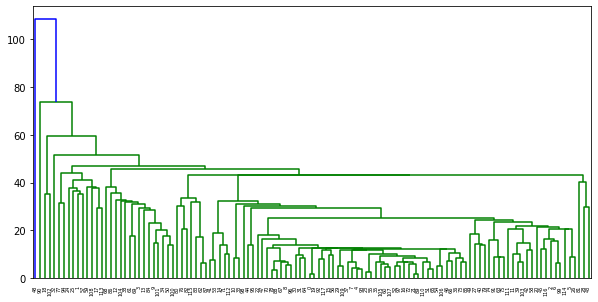

In [135]:
#Hierarchial clustering
#Batting data
# Single linkage
plt.figure(figsize = (10,5))
mergings = linkage(batdf, method='single',metric='euclidean')
dendrogram(mergings)
plt.show()

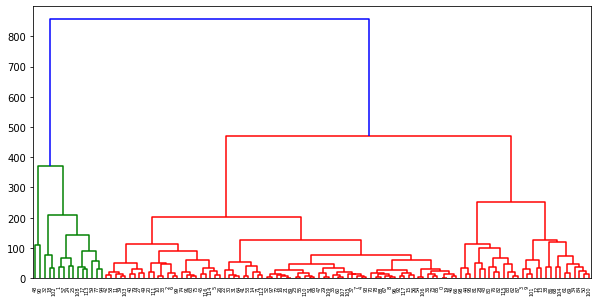

In [134]:
# Complete Linkage
plt.figure(figsize = (10,5))
mergings = linkage(batdf, method='complete',metric='euclidean')
dendrogram(mergings)
plt.show()

In [110]:
batdf_hc = batdf.copy()
batdf_hc = batdf_hc.drop('cluster',axis=1)
batdf_hc.head()

,balls_faced,innings,runs,4s,6s,average_runs,strike_rate
batsman,,,,,,,
A Nortje,6,3,7,0.0,0.0,2.33,116.67
AB de Villiers,292,14,454,33.0,23.0,32.43,155.48
AD Russell,82,9,117,9.0,9.0,13.00,142.68
AJ Finch,254,12,268,28.0,8.0,22.33,105.51
AJ Tye,7,1,6,0.0,1.0,6.00,85.71


In [111]:
#complete linkage suggests 3 clusters
cluster_labels_bat = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels_bat

array([0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2,
       2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 2, 2, 0, 0, 0,
       0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2,
       0, 0, 1, 0, 0, 0, 1, 2, 0, 0, 2, 0, 2, 2, 1, 0, 2, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 2, 0, 0])

In [115]:
# assign cluster labels
batdf_hc['Cluster_labels'] = cluster_labels_bat
batdf_hc.head()

,balls_faced,innings,runs,4s,6s,average_runs,strike_rate,Cluster_labels
batsman,,,,,,,,
A Nortje,6,3,7,0.0,0.0,2.33,116.67,0
AB de Villiers,292,14,454,33.0,23.0,32.43,155.48,1
AD Russell,82,9,117,9.0,9.0,13.00,142.68,0
AJ Finch,254,12,268,28.0,8.0,22.33,105.51,2
AJ Tye,7,1,6,0.0,1.0,6.00,85.71,0


In [116]:
#no of batsmen in each cluster
batdf_hc.Cluster_labels.value_counts(ascending=True)

1    15
2    28
0    75
Name: Cluster_labels, dtype: int64

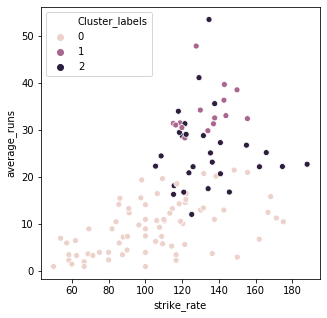

In [133]:
# Scatter plot on Original attributes to visualize the spread of the data
plt.figure(figsize = (5,5))
sns.scatterplot(x = 'strike_rate', y = 'average_runs',hue='Cluster_labels',data = batdf_hc,legend='full')

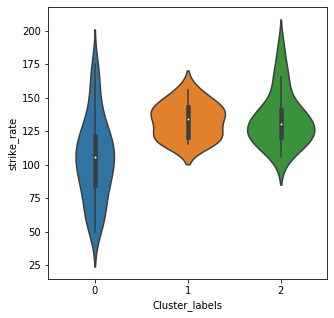

In [131]:
fig = plt.figure(figsize=(5,5))

sns.violinplot(x = 'Cluster_labels', y = 'strike_rate', data = batdf_hc)

In [139]:
#average values for each cluster
batdf_hc[['average_runs','strike_rate','Cluster_labels']].groupby('Cluster_labels').mean()

,average_runs,strike_rate
Cluster_labels,,
0,9.428133,104.387067
1,33.924000,132.848667
2,25.537857,133.994643


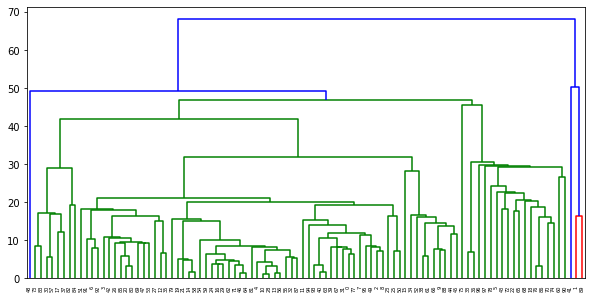

In [140]:
#Hierarchial clustering
#Bowling data
# Single linkage
plt.figure(figsize = (10,5))
mergings = linkage(bowldf, method='single',metric='euclidean')
dendrogram(mergings)
plt.show()

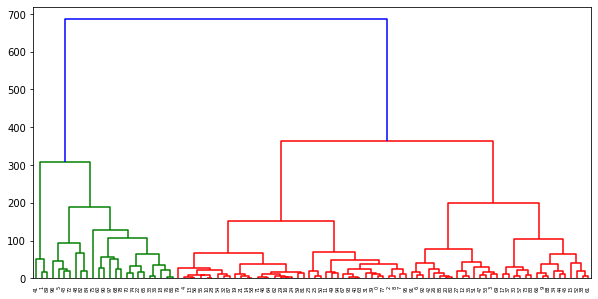

In [141]:
# Complete Linkage
plt.figure(figsize = (10,5))
mergings = linkage(bowldf, method='complete',metric='euclidean')
dendrogram(mergings)
plt.show()

In [142]:
bowldf_hc = bowldf.copy()
bowldf_hc = bowldf_hc.drop('cluster',axis=1)
bowldf_hc.head()

,balls_bowled,overs,wickets,runs_given,economy,cluster_b
bowler,,,,,,
A Mishra,61,10,3.0,72.0,7.20,0
A Nortje,376,62,22.0,512.0,8.26,1
A Zampa,67,11,2.0,92.0,8.36,3
AD Russell,114,18,6.0,175.0,9.72,3
AJ Tye,27,4,1.0,49.0,12.25,0


In [144]:
#complete linkage suggests 3 clusters
cluster_labels_bowl = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels_bowl

array([0, 1, 0, 2, 0, 1, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 1, 0, 2, 0,
       1, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 1, 2, 2, 1, 2, 2, 0, 0, 1, 2, 1,
       2, 2, 0, 2, 1, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 1, 2, 0, 0, 0, 1,
       2, 0, 1, 2, 1, 0, 1, 2, 1, 1, 1, 0, 1, 0, 2, 0, 1, 2, 1, 2, 1, 0,
       2, 1, 1, 2, 2, 0, 0, 0, 1, 1])

In [145]:
# assign cluster labels
bowldf_hc['Cluster_labels'] = cluster_labels_bowl
bowldf_hc.head()

,balls_bowled,overs,wickets,runs_given,economy,cluster_b,Cluster_labels
bowler,,,,,,,
A Mishra,61,10,3.0,72.0,7.20,0,0
A Nortje,376,62,22.0,512.0,8.26,1,1
A Zampa,67,11,2.0,92.0,8.36,3,0
AD Russell,114,18,6.0,175.0,9.72,3,2
AJ Tye,27,4,1.0,49.0,12.25,0,0


In [146]:
#no of bowlers in each cluster
bowldf_hc.Cluster_labels.value_counts(ascending=True)

1    25
2    32
0    41
Name: Cluster_labels, dtype: int64

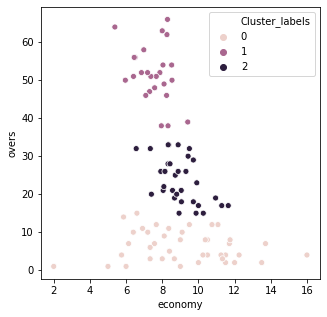

In [148]:
# Scatter plot on original attributes to visualize the spread of the data
plt.figure(figsize = (5,5))
sns.scatterplot(x = 'economy', y = 'overs',hue='Cluster_labels',data = bowldf_hc,legend='full')

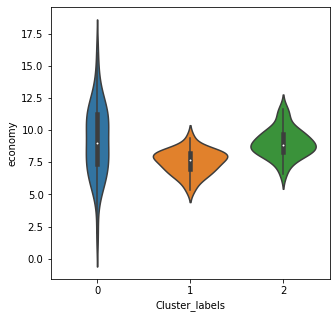

In [149]:
fig = plt.figure(figsize=(5,5))

sns.violinplot(x = 'Cluster_labels', y = 'economy', data = bowldf_hc)

In [150]:
#Average values for each cluster
bowldf_hc[['overs','economy','Cluster_labels']].groupby('Cluster_labels').mean()

,overs,economy
Cluster_labels,,
0,6.365854,9.167317
1,51.720000,7.530800
2,23.656250,9.004375
